In [50]:
import numpy as np
import math
import nibabel as nib
import cv2
from skimage import measure
from skimage import morphology
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.spatial import ConvexHull

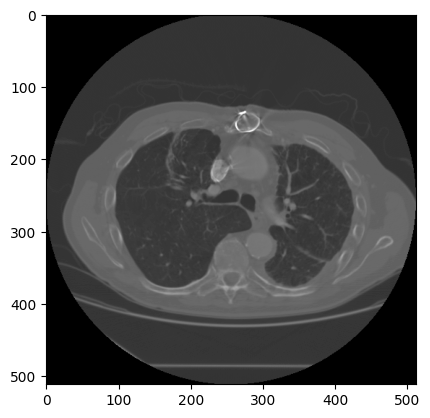

In [51]:
fname = './images/Images/IMG_0011.nii.gz'

foo = nib.load(fname).get_fdata()

plt.imshow(foo[:,:,100],cmap='gray')

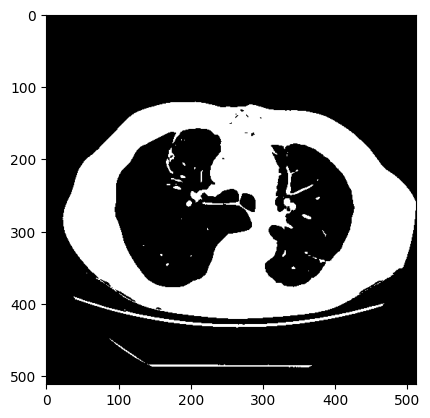

In [52]:
# run binarization with treshold HU = -320
binary_image = np.where(foo < -320, 0, 1)
plt.imshow(binary_image[:,:,100],cmap='gray')

In [53]:
def get_body_mask(foo):
    body_mask = np.array(foo)
    for i in range(0,foo.shape[2]):
        # Remove small objects (air bubbles and noise) using morphological opening
        cleaned_image = morphology.remove_small_objects(binary_image[:,:,i].astype(bool), min_size=500)

        # Fill holes inside the binary mask
        filled_image = ndimage.binary_fill_holes(cleaned_image)

        # Label connected components
        labels = measure.label(filled_image)

        # Find the largest component (the body)
        props = measure.regionprops(labels)
        props = sorted(props, key=lambda x: x.area, reverse=True)

        # Create an empty mask and fill it with the largest region (body)
        body_mask[:,:,i] = np.zeros_like(labels)
        body_mask[:,:,i][labels == props[0].label] = 1
        body_mask[:,:,i] = cv2.erode(body_mask[:,:,i].astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))

    # Display the final segmented body image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(foo[:,:,50], cmap='gray')
    ax[0].set_title("Original Image")
    ax[1].imshow(body_mask[:,:,50], cmap='gray')
    ax[1].set_title("Segmented body")
    plt.title("Segmented body")
    plt.show()

    return body_mask

In [54]:
def get_lung_mask(foo):
    lung_mask = np.array(foo)

    for i in range(0,foo.shape[2]):
        # Remove small objects (air bubbles and noise) using morphological opening
        cleaned_image = morphology.remove_small_objects(binary_image[:,:,i].astype(bool), min_size=500)

        # Invert image
        cleaned_image = np.where(cleaned_image == 0, 1, 0)
        cleaned_image = cv2.erode(cleaned_image.astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
        labels = measure.label(cleaned_image)

        # Find the largest two components (the lungs)
        props = measure.regionprops(labels)
        props = sorted(props, key=lambda x: x.area, reverse=True)

        # Create an empty mask and fill it with the two largest regions (lungs)
        lung_mask[:,:,i] = np.zeros_like(labels)
        for prop in props[1:3]:
            lung_mask[:,:,i][labels == prop.label] = 1
            lung_mask[:,:,i] = cv2.dilate(lung_mask[:,:,i].astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
            lung_mask[:,:,i] = cv2.morphologyEx(lung_mask[:,:,i], cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))

        #label the right and left lung
        right_lung = np.zeros_like(labels)
        left_lung = np.zeros_like(labels)
        for prop in props[1:3]:
            if prop.centroid[1] > foo.shape[1] / 2:
                right_lung[labels == prop.label] = 1
            else:
                left_lung[labels == prop.label] = 2

        lung_mask[:,:,i] = right_lung + left_lung


    # Display the final segmented body image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(foo[:,:,50], cmap='gray')
    ax[0].set_title("Original Image")
    ax[1].imshow(lung_mask[:,:,50], cmap='gray')
    ax[1].set_title("Segmented lungs")
    plt.title("Segmented lungs")
    plt.show()

    return lung_mask


In [55]:
from surface_distance import metrics

def evaluate_segmentation(lung_mask, ref):
    # Compute surface distances
    dice_coefficient = metrics.compute_dice_coefficient(lung_mask.astype(bool), ref.astype(bool))
    distance = metrics.compute_surface_distances(lung_mask.astype(bool), ref.astype(bool), spacing_mm=(1, 1, 1))
    hausdorff_distance = metrics.compute_robust_hausdorff(distance, 95)
    print("Dice coefficient: ", dice_coefficient)
    print("Hausdorff distance: ", hausdorff_distance)

    return dice_coefficient, hausdorff_distance

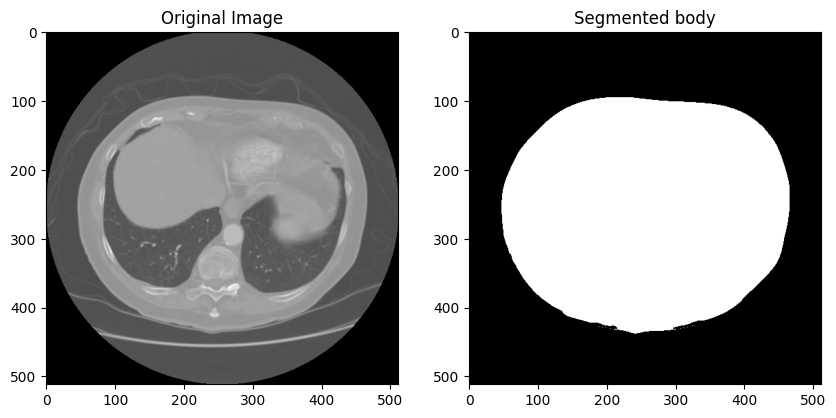

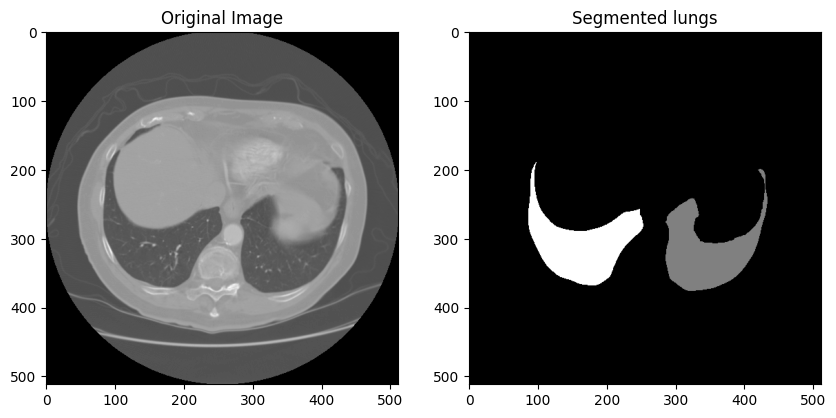

Dice coefficient:  0.0011103347860925987
Hausdorff distance:  249.11844572411735
Dice coefficient:  0.8292693366859153
Hausdorff distance:  265.46939559956814
Dice coefficient:  0.9960439921266635
Hausdorff distance:  1.0


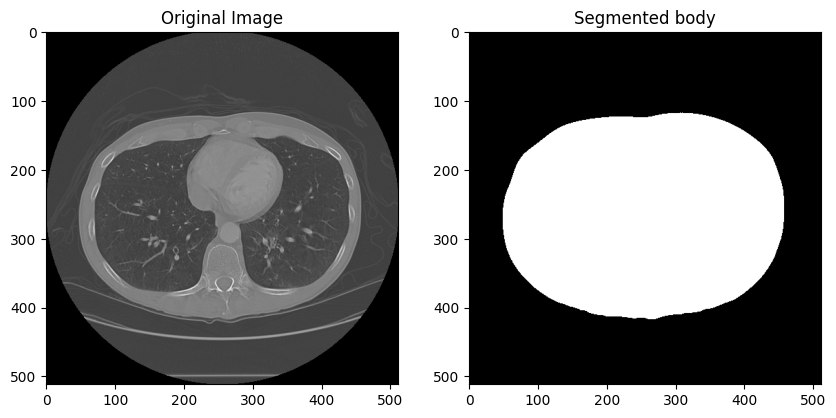

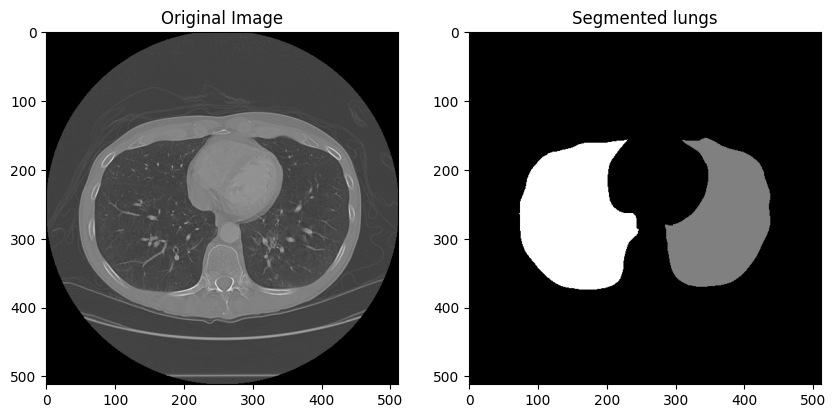

Dice coefficient:  0.0029556797835540976
Hausdorff distance:  234.51012771306915
Dice coefficient:  0.8134195589930292
Hausdorff distance:  144.2497833620557
Dice coefficient:  0.9963252296687214
Hausdorff distance:  1.0


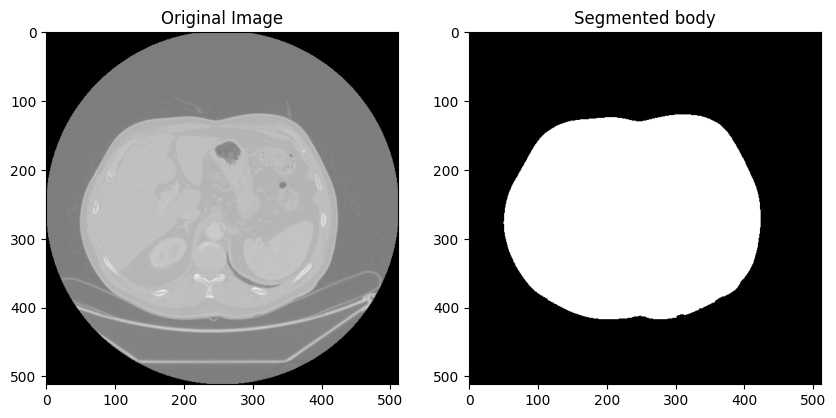

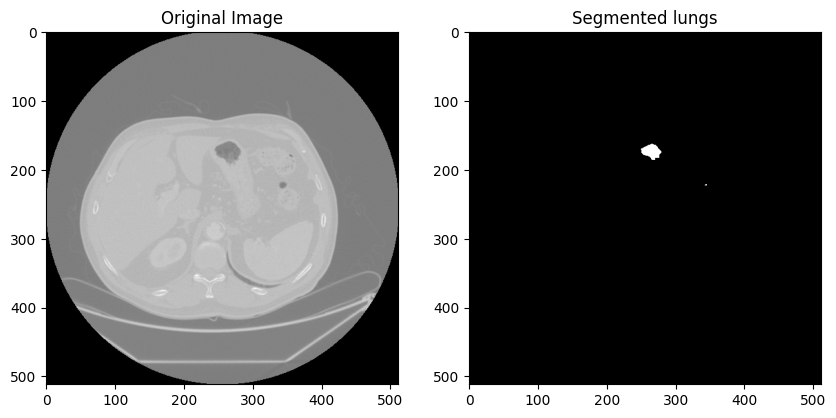

Dice coefficient:  0.0002888221338898498
Hausdorff distance:  99.65440281292142
Dice coefficient:  0.8988967413456025
Hausdorff distance:  7.483314773547883
Dice coefficient:  0.9957319503531624
Hausdorff distance:  1.0


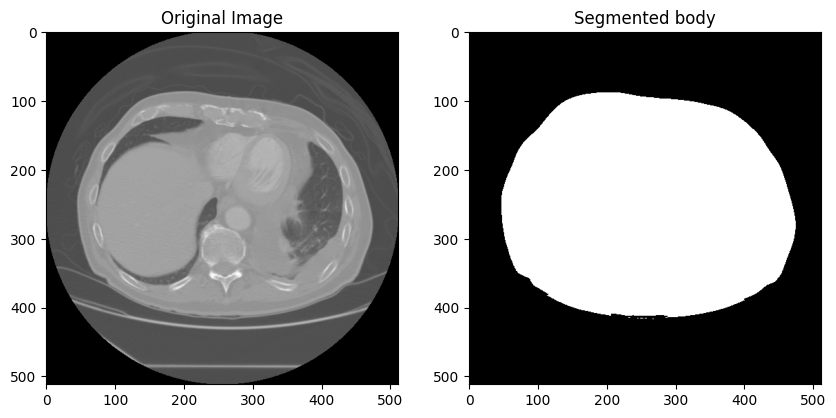

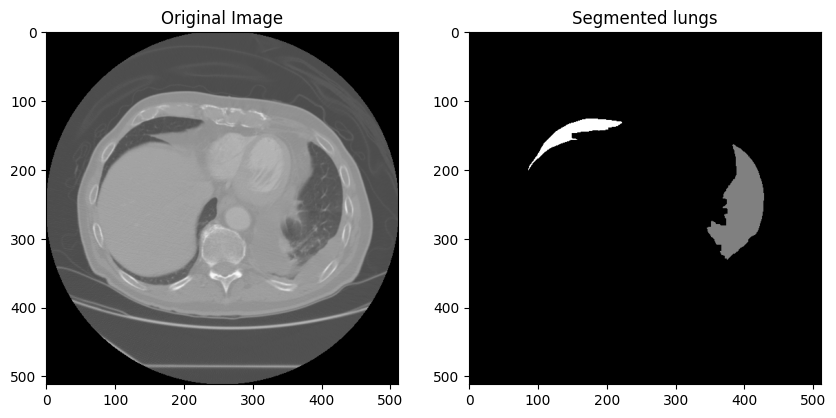

In [ ]:
import os
import nibabel as nib
import numpy as np

coefficients_right_lung = []
dist_right_lung = []
coefficients_left_lung = []
dist_left_lung = []
coefficients_body = []
dist_body = []

def get_lungs_from_labels(lung_mask, right_label=1, left_label=2):
    """Extract right and left lung masks based on labels."""
    right_lung_mask = (lung_mask == right_label).astype(np.uint8)  # Right lung based on label
    left_lung_mask = (lung_mask == left_label).astype(np.uint8)    # Left lung based on label
    return right_lung_mask, left_lung_mask

for file in os.listdir('./images/Images/'):
    if file.endswith('.nii.gz'):
        fname = './images/Images/' + file
        foo = nib.load(fname).get_fdata()

        # Thresholding for lung segmentation
        binary_image = np.where(foo < -320, 0, 1)

        body_mask = get_body_mask(foo)
        lung_mask = get_lung_mask(foo)

        # Load labeled reference segmentation for lungs
        ref_lungs = nib.load('./ReferenceSegmentations/LUNGS_' + file).get_fdata()

        # Extract right and left lungs from labeled reference (e.g., label 1 = right, label 2 = left)
        ref_right_lung, ref_left_lung = get_lungs_from_labels(ref_lungs, right_label=1, left_label=2)

        # Extract predicted right and left lungs from the segmented mask
        pred_right_lung, pred_left_lung = get_lungs_from_labels(lung_mask, right_label=1, left_label=2)

        # Evaluate right lung
        dice_coefficient, hausdorff_distance = evaluate_segmentation(pred_right_lung, ref_right_lung)
        coefficients_right_lung.append(dice_coefficient)
        dist_right_lung.append(hausdorff_distance)

        # Evaluate left lung
        dice_coefficient, hausdorff_distance = evaluate_segmentation(pred_left_lung, ref_left_lung)
        coefficients_left_lung.append(dice_coefficient)
        dist_left_lung.append(hausdorff_distance)

        # Load reference for body mask
        ref_body = nib.load('./BodyMasks/BODYMASK_' + file).get_fdata()
        ref_body = (ref_body > 0).astype(np.uint8)

        # Evaluate body mask
        dice_coefficient, hausdorff_distance = evaluate_segmentation(body_mask, ref_body)
        coefficients_body.append(dice_coefficient)
        dist_body.append(hausdorff_distance)

# Print results for right and left lung and body
print("Mean Dice coefficient for right lung: ", np.mean(coefficients_right_lung))
print("Mean Hausdorff distance for right lung: ", np.mean(dist_right_lung))
print("Mean Dice coefficient for left lung: ", np.mean(coefficients_left_lung))
print("Mean Hausdorff distance for left lung: ", np.mean(dist_left_lung))

print("Mean Dice coefficient for body: ", np.mean(coefficients_body))
print("Mean Hausdorff distance for body: ", np.mean(dist_body))


In [ ]:
import os

coefficients_lungs = []
dist_lungs = []
coefficients_body = []
dist_body = []
for file in os.listdir('./images/Images/'):
    if file.endswith('.nii.gz'):
        fname = './images/Images/' + file
        foo = nib.load(fname).get_fdata()
        binary_image = np.where(foo < -320, 0, 1)
        body_mask = get_body_mask(foo)
        lung_mask = get_lung_mask(foo)

        ref = nib.load('./ReferenceSegmentations/LUNGS_' + file).get_fdata()
        for i in range(0, ref.shape[2]):
            ref[:,:,i] = ref[:,:,i] > 0

        dice_coefficient, hausdorff_distance = evaluate_segmentation(lung_mask, ref)
        coefficients_lungs.append(dice_coefficient)
        dist_lungs.append(hausdorff_distance)

        ref = nib.load('./BodyMasks/BODYMASK_' + file).get_fdata()
        for i in range(0, ref.shape[2]):
            ref[:,:,i] = ref[:,:,i] > 0

        dice_coefficient, hausdorff_distance = evaluate_segmentation(body_mask, ref)
        coefficients_body.append(dice_coefficient)
        dist_body.append(hausdorff_distance)


print("Mean dice coefficient for lungs: ", np.mean(coefficients_lungs))
print("Mean Hausdorff distance for lungs: ", np.mean(dist_lungs))
print("Mean dice coefficient for body: ", np.mean(coefficients_body))
print("Mean Hausdorff distance for body: ", np.mean(dist_body))
